In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

tensor(5)


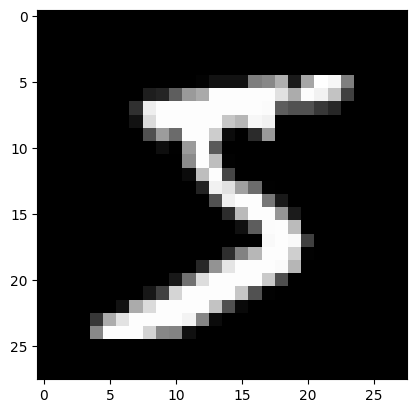

In [118]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [119]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model as a subclass of nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        for i in range(1, input_dim): # must split them as different parameters :?
            self.param_rows = nn.ParameterList([nn.Parameter(torch.randn(num_classes)) for i in range(input_dim)])
    
    def param_matrix(self):
        return torch.stack(list(self.param_rows), dim=0)
    
    def forward(self, x):
        return x @ self.param_matrix()
    
def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    # we substract max_logits from exponential 
    # and then add them back for numerical stability
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar

    alpha_term = 0.5 * alpha * torch.sum(model.param_matrix() ** 2)

    return loss_data + alpha_term

In [127]:
def train(model, train_loader, alpha, optimizer, optimizer_params,
          num_epochs=10):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            opt.step()
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        epoch_losses.append(loss.item())

    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for alpha = {}'.format(alpha))
    plt.show()

    return model

In [128]:
def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total

In [129]:
from torch.utils.data import DataLoader, TensorDataset

def solve_bilevel(alpha_range,
                   train_data,
                   val_loader,
                   optimizer,
                   optimizer_params,
                   num_epochs=10,
                   batch_size=64):
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))

    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        model = LogisticRegression(input_dim, num_classes)
        model = train(model, train_loader, alpha, optimizer, optimizer_params, num_epochs)
        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')

        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model
    
    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model

In [130]:
from torch.optim import Optimizer

class CoordinateDescent(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(CoordinateDescent, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        coord = torch.randint(high=len(self.param_groups), size=(1,))
        for group in self.param_groups:
            p = group['params'][coord]
            if p.grad is None:
                continue
            d_p = p.grad
            p.data.add_(-group['lr'], d_p)
        return loss

In [131]:
# CONSTANTS
ALPHA_RANGE = [0.0001]
NUM_EPOCHS = 5
OPTIMIZER_PARAMS = {'lr': 0.1}
BATCH_SIZE = 64
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = CoordinateDescent

In [132]:


train_data = TensorDataset(x_train, y_train)
print(train_data.tensors[0].shape[1])
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha, best_acc, best_model = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

784
Alpha: 0.0001
Epoch 0, Loss: 8.700695991516113
Epoch 0, Loss: 12.523863792419434
Epoch 0, Loss: 10.318155288696289
Epoch 0, Loss: 10.670256614685059
Epoch 0, Loss: 9.47836971282959
Epoch 0, Loss: 11.140911102294922
Epoch 0, Loss: 13.002553939819336
Epoch 0, Loss: 11.54727840423584
Epoch 0, Loss: 12.804672241210938
Epoch 0, Loss: 11.096247673034668
Epoch 0, Loss: 13.809704780578613
Epoch 0, Loss: 13.274652481079102
Epoch 0, Loss: 11.311492919921875
Epoch 0, Loss: 12.368200302124023
Epoch 0, Loss: 10.992149353027344
Epoch 0, Loss: 11.77515697479248
Epoch 0, Loss: 12.27857780456543
Epoch 0, Loss: 9.90941333770752
Epoch 0, Loss: 12.367757797241211
Epoch 0, Loss: 11.782257080078125
Epoch 0, Loss: 10.659920692443848
Epoch 0, Loss: 11.394659996032715
Epoch 0, Loss: 11.901174545288086
Epoch 0, Loss: 13.840437889099121
Epoch 0, Loss: 12.28904914855957
Epoch 0, Loss: 9.51913070678711
Epoch 0, Loss: 11.686558723449707
Epoch 0, Loss: 10.543651580810547
Epoch 0, Loss: 9.002994537353516
Epoch 0,

KeyboardInterrupt: 

In [60]:
# Test the best model
x_test = test_data.data.view(-1, 28*28).float() / 255.0
y_test = test_data.targets
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_acc = test(best_model, test_loader)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.9089
